In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matlab.engine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import math
solvers.options['show_progress'] = False

eng = matlab.engine.start_matlab()
quarters = [('-01-01', '-03-31'), ('-04-01', '-06-30'), ('-07-01', '-09-30'), ('-10-01', '-12-31')]
years = [
    ('2016-01-01','2016-12-31'), 
    ('2017-01-01','2017-12-31'),
    ('2018-01-01','2018-12-31'), 
    ('2019-01-01','2019-12-31'), 
    ('2020-01-01','2020-12-31')
]
mu_si = np.array([0.22, 0.33, 0.30, 0.33, 0.54, 0.63, 0.98, 1.02, 1.44, 1.63, 1.91, 2.13, 2.42, 2.44, 2.35, 1.98, 1.54, 1.12, 0.14, 0.12])/100
mu_cl = np.add(mu_si, [.03]*20)
mu_si = mu_si/252
mu_cl = mu_cl/252

mu_safe = {}
mu_credit = {}

for year_index, year in enumerate(years):
    for quarter_index in range(4):
        mu_safe[year[0][:4] + ' Q' + str(quarter_index + 1)] = mu_si[year_index*4 + quarter_index]
        mu_credit[year[0][:4] + ' Q' + str(quarter_index + 1)] = mu_cl[year_index*4 + quarter_index]

mu_si = mu_safe
mu_cl = mu_credit 

# assets = ['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX', 'AMZN', 'WMT', 'CVS']
# df = yf.download(assets, '2015-12-31', '2021-01-05')['Adj Close'].reindex(columns=assets)
# returns = (df - df.shift(1))/df.shift(1)

In [3]:
# Tested and returns same as matlab
def compute_y(var):
    ones = eng.transpose(matlab.double([1]*len(var)))
    return eng.mldivide(matlab.double(var.values.tolist()), matlab.double(ones))._data.tolist()

# Tested and returns same as matlab
def compute_z(mean, variance):
    return eng.mldivide(matlab.double(variance.values.tolist()), eng.transpose(matlab.double(mean.values.tolist())))._data.tolist()

# np.dot values return the same as matlab for test data
def compute_abc(mean, variance):
    y = compute_y(variance)
    z = compute_z(mean, variance)
    ones = [1]*len(mean)
    # a = sum(eng.times(ones, matlab.double(y))._data)
    # b = sum(eng.times(ones, matlab.double(z))._data)
    # c = sum(eng.times(ones, matlab.double(mean.values.tolist()))._data)
    return np.sum(np.array(ones).conj()*y, axis=0), np.sum(np.array(ones).conj()*z, axis=0), np.sum(np.array(mean.values.tolist()).conj()*z, axis=0)
    # return a,b,c

# returns same values as matlab
def compute_mv_vars(mean, variance):
    a,b,c = compute_abc(mean, variance)
    sigma_mv = 1/(a**0.5)
    mu_mv = b/a
    nu_as = ((a*c - b**2)/a)**0.5
    return sigma_mv, mu_mv, nu_as

    
def is_solvent(portfolio, returns):
    return not any(y <= 0 for y in [1 + np.dot(portfolio, returns.iloc[day]) for day in range(len(returns))])

def is_long(portfolio):
    return not any(y < 0 for y in portfolio.tolist())

In [4]:
class Portfolio:
    def __init__(self, assets, name, start_date='2015-12-28', end_date='2021-01-05'):
        self.data = yf.download(assets, start_date, end_date)['Adj Close']
        self.data = self.data.reindex(columns=assets)
        self.returns = (self.data - self.data.shift(1))/self.data.shift(1)
        self.start_date = start_date
        self.end_date = end_date
        self.portfolio_name = name
        
    # Returns mean and variance of portfolio for period
    def get_mean_and_variance(self, period_start = None, period_end = None):
        
        # Can add checks to make sure dates are valid with data that is contained
        if period_start is not None and period_end is not None:
            return self.returns[period_start:period_end].mean(), self.returns[period_start:period_end].cov()
        
        return self.returns.mean(), self.returns.cov()

    # Returns minimum volatility portfolio allocation and parameters
    def get_minimum_volatility_portfolio_parameters(self, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        sigma_mv, mu_mv, nu_as = compute_mv_vars(m, V)
        y = compute_y(V)

        f_mv = (sigma_mv**2)*np.array(y)

        return pd.Series(data=f_mv, index=self.data.columns), sigma_mv, mu_mv, nu_as

    # Returns safe tangent portfolio allocation if it exists and relevant parameters
    def get_safe_tangent_portfolio_parameters(self, mu_si, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        f_mv, sigma_mv, mu_mv, nu_as = Portfolio.get_minimum_volatility_portfolio_parameters(self, period_start, period_end)

        if mu_mv < mu_si:
            return None
        
        sigma_st = sigma_mv*(1 + ((nu_as*sigma_mv)/(mu_mv-mu_si))**2)**0.5
        mu_st = mu_mv + (nu_as**2)*(sigma_mv**2)/(mu_mv-mu_si)
        nu_st = nu_as*(1 + ((mu_mv-mu_si)/(nu_as*sigma_mv))**2)**0.5

        y = compute_y(V)
        z = compute_z(m, V)

        f_st = (sigma_mv**2/(mu_mv-mu_si))*(z - mu_si*np.array(y)).reshape((len(m)))

        return pd.Series(data=f_st, index=self.data.columns), sigma_st, mu_st, nu_st

    def get_credit_tangent_portfolio_parameters(self, mu_cl, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        f_mv, sigma_mv, mu_mv, nu_as = Portfolio.get_minimum_volatility_portfolio_parameters(self, period_start, period_end)

        if mu_mv < mu_cl:
            return None

        sigma_ct = sigma_mv*(1 + ((nu_as*sigma_mv)/(mu_mv-mu_cl))**2)**0.5
        mu_ct = mu_mv + (nu_as**2)*(sigma_mv**2)/(mu_mv-mu_cl)
        nu_ct = nu_as*(1 + ((mu_mv-mu_cl)/(nu_as*sigma_mv))**2)**0.5

        y = compute_y(V)
        z = compute_z(m, V)

        f_ct = (sigma_mv**2/(mu_mv-mu_cl))*(z - mu_cl*np.array(y)).reshape((len(m)))

        return pd.Series(data=f_ct, index=self.data.columns), sigma_ct, mu_ct, nu_ct
        
    def get_long_tangent_portfolio(self, mu_si, period_start=None, period_end=None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        mu_start = min(m)
        mu_end = max(m)
        step_size = (mu_end - mu_start)/300

        long_mus = np.arange(mu_start, mu_end + step_size, step_size)

        # Long Frontier
        Q = matrix(V.values, tc='d')
        z = matrix(np.zeros((len(V))).tolist(), tc='d')
        I = matrix((-1*np.identity(len(V))), tc='d')
        A = matrix(np.array([np.ones((len(V))).tolist(), m.values.tolist()]), tc='d')

        nu_ca = (None, None, None, -100)
        
        # Will need to adjust for time periods longer than a year
        year = period_start[:4]

        for cur_mu in long_mus:
            deq = matrix(np.array([1, cur_mu]), tc='d')
            sol = solvers.qp(Q, z, I, z, A, deq)
            current_long_allocation = np.reshape(np.array(sol['x']), (len(m)))            

            sigma_lf = (np.matmul(np.matmul(current_long_allocation, V.values), np.reshape(current_long_allocation, (len(current_long_allocation),1)))[0])**0.5
            
            # Finding capital allocation line with greatest slope
            curNu_ca = (cur_mu - mu_si)/sigma_lf

            if curNu_ca > nu_ca[-1]:
                nu_ca = (current_long_allocation, sigma_lf, cur_mu, curNu_ca)

        return nu_ca

In [29]:
def calculateSignalToNoiseForEstimators(expectedValue, stdDev, gamma):
    return (expectedValue - gamma)/ stdDev
    
def getVarianceEstimators(f_vector, mean, Var, expectedValue, stdDev):

    estimators = pd.DataFrame(columns = ['estimator name','estimator value', 'signal to Noise'])
    gamma_q = np.transpose(mean) @ f_vector - (np.transpose(f_vector)@ (mean @ np.transpose(mean) + Var) @ f_vector) * (1/2)
    gamma_p = np.transpose(mean) @ f_vector - (np.transpose(f_vector)@ (Var) @ f_vector) * (1/2)
    gamma_t = np.log(1 + np.transpose(mean) @ f_vector) - (np.transpose(f_vector)@ (Var) @ f_vector) * (1/(2* np.square(1 + np.transpose(mean) @ f_vector)))
    gamma_r = np.log(1 + np.transpose(mean) @ f_vector) - (np.transpose(f_vector)@ (Var) @ f_vector) * (1/2)
    gamma_s = np.log(1 + np.transpose(mean) @ f_vector) - (np.transpose(f_vector)@ (Var) @ f_vector) * (1/(2* (1 + 2 * np.transpose(mean) @ f_vector)))
    
    estimators.loc[len(estimators.index)] = ['gamma q', gamma_q, calculateSignalToNoiseForEstimators(expectedValue, stdDev, gamma_q)] 
    estimators.loc[len(estimators.index)] = ['gamma p', gamma_p, calculateSignalToNoiseForEstimators(expectedValue, stdDev, gamma_p)] 
    estimators.loc[len(estimators.index)] = ['gamma t', gamma_t, calculateSignalToNoiseForEstimators(expectedValue, stdDev, gamma_t)] 
    estimators.loc[len(estimators.index)] = ['gamma r', gamma_r, calculateSignalToNoiseForEstimators(expectedValue, stdDev, gamma_r)] 
    estimators.loc[len(estimators.index)] = ['gamma s', gamma_s, calculateSignalToNoiseForEstimators(expectedValue, stdDev, gamma_s)] 
    return estimators

In [5]:
groupA = Portfolio(['VFIAX', 'VBTLX', 'VGSLX'], 'Group A')
groupAB = Portfolio(['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX'], 'Group AB')
groupABC = Portfolio(['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX', 'AMZN', 'WMT', 'CVS'], 'Group ABC')

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  9 of 9 completed


In [6]:
lgd_groupA = mpatches.Patch(color='blue', label='Group A')
lgd_groupAB = mpatches.Patch(color='red', label='Group AB (And Assets Not Included in A)')
lgd_groupABC = mpatches.Patch(color='green', label='Group ABC (And Assets Not Included in AB)')
assets = Line2D([0], [0], marker='o', color='w', markerfacecolor='k', label='Assets', markersize=12)
rf = Line2D([0], [0], marker='D', color='w', markerfacecolor='k', label='Risk Free Rates', markersize=12)
ctg = Line2D([0], [0], marker='*', color='w', markerfacecolor='k', label='Credit Tangent Portfolio', markersize=12)
stg = Line2D([0], [0], marker='^', color='w', markerfacecolor='k', label='Safe Tangent Portfolio', markersize=12)
ltg = Line2D([0], [0], marker='X', color='w', markerfacecolor='k', label='Long Tangent Portfolio', markersize=12)
equi = Line2D([0], [0], marker='P', color='w', markerfacecolor='k', label='Equidistributed Portfolio', markersize=12)
mv_portfolio = Line2D([0], [0], marker='s', color='w', markerfacecolor='k', label='Minimum Variance Portfolio', markersize=12)
mv_frontier = Line2D([0], [0], linewidth=1., color='k', label='Minimum Variance Frontier', markersize=12)
efficient_frontier = Line2D([0], [0], linestyle='--', linewidth=1., color='k', label='Efficient Frontier', markersize=12)
efficient_frontier.set_linestyle('--')
long_frontier = Line2D([0], [0], linestyle=':', linewidth=1., color='k', label='Long Frontier', markersize=12)
long_frontier.set_linestyle(':')
lmtd_frontier_1 = Line2D([0], [0], linestyle='-.', linewidth=1., color='m', label='Limited Leverage Frontier (l = 1)', markersize=12)
lmtd_frontier_1.set_linestyle('-.')
lmtd_frontier_5 = Line2D([0], [0], linestyle='-.', linewidth=1., color='c', label='Limited Leverage Frontier (l = 5)', markersize=12)
lmtd_frontier_5.set_linestyle('-.')

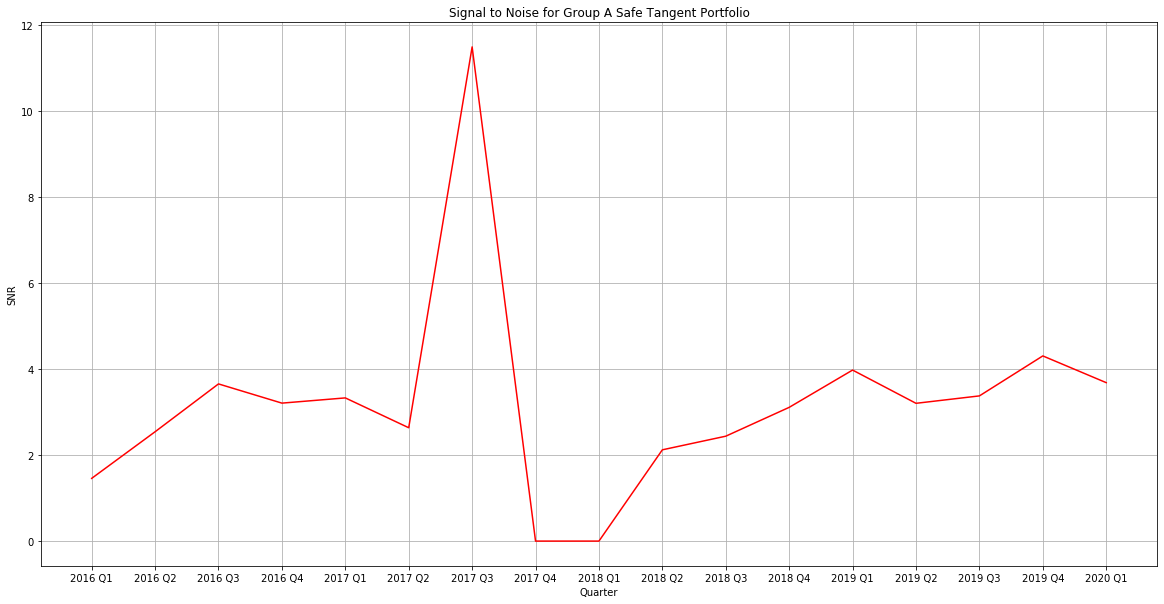

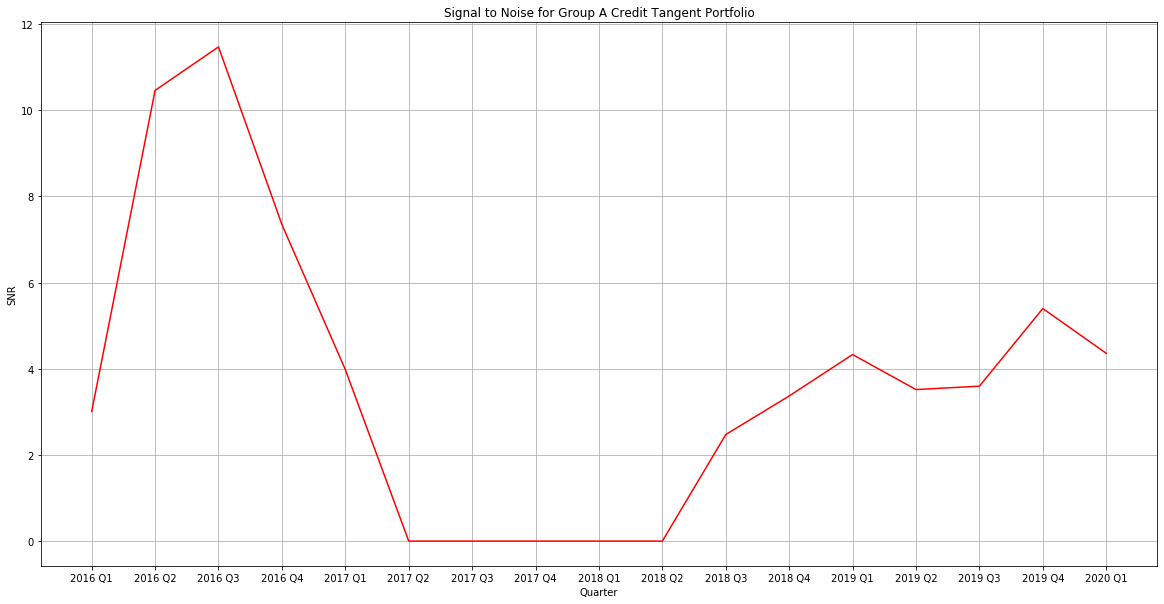

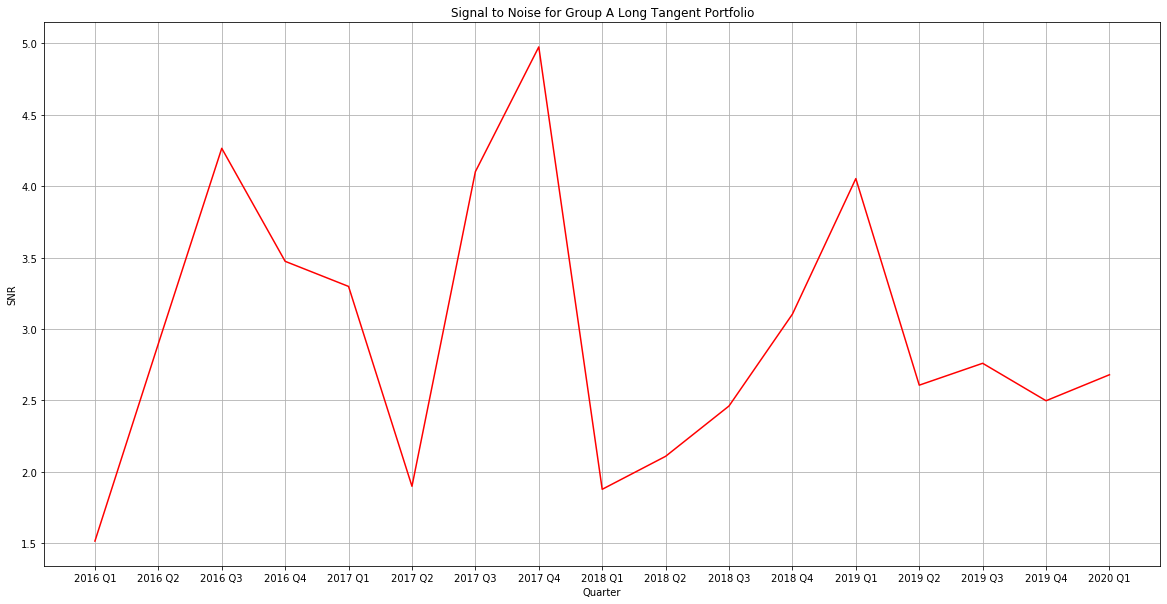

'Safe Tangent Group A'

,Gamma Q,Gamma P,Gamma T,Gamma R,Gamma S
2016 Q1,0.001449,-0.000064,0.000069,0.000075,0.000069
2016 Q2,0.011449,0.009725,0.010128,0.010146,0.010128
2016 Q3,0.001023,-0.000697,0.000146,0.000181,0.000146
2016 Q4,-0.011479,-0.013338,-0.012683,-0.012664,-0.012683
2017 Q1,-0.011224,-0.013925,-0.013213,-0.013204,-0.013213
2017 Q2,-0.020120,-0.021397,-0.020957,-0.020937,-0.020957
2017 Q3,-0.107548,-0.108538,-0.106653,-0.089691,-0.106631
2018 Q2,-0.005580,-0.008666,-0.008382,-0.008372,-0.008382
2018 Q3,-0.017716,-0.019836,-0.019454,-0.019448,-0.019454
2018 Q4,-0.009850,-0.012945,-0.012326,-0.012315,-0.012326


'Credit Tangent Group A'

,Gamma Q,Gamma P,Gamma T,Gamma R,Gamma S
2016 Q1,0.001363,-0.000143,0.000370,0.000504,0.000370
2016 Q2,0.030228,0.028830,0.035326,0.039365,0.035329
2016 Q3,-0.004212,-0.005525,0.004154,0.006980,0.004157
2016 Q4,-0.030407,-0.032139,-0.028568,-0.028206,-0.028568
2017 Q1,-0.014144,-0.016830,-0.015805,-0.015788,-0.015805
2018 Q3,-0.018020,-0.020139,-0.019746,-0.019739,-0.019746
2018 Q4,-0.010997,-0.014086,-0.013359,-0.013342,-0.013359
2019 Q1,0.008217,-0.001143,0.000067,0.000088,0.000068
2019 Q2,0.014880,0.013493,0.014264,0.014309,0.014264
2019 Q3,0.015037,0.013569,0.014377,0.014421,0.014377


'Long Tangent Group A'

,Gamma Q,Gamma P,Gamma T,Gamma R,Gamma S
2016 Q1,0.001448,-0.000065,0.000078,0.000085,0.000078
2016 Q2,0.012769,0.011048,0.011566,0.011602,0.011566
2016 Q3,0.000795,-0.000915,0.000227,0.000309,0.000227
2016 Q4,-0.012621,-0.014476,-0.013709,-0.013678,-0.013709
2017 Q1,-0.011091,-0.013793,-0.013094,-0.013083,-0.013094
2017 Q2,-0.014087,-0.015366,-0.015141,-0.015125,-0.015141
2017 Q3,-0.016681,-0.017970,-0.017009,-0.016742,-0.017009
2017 Q4,-0.020082,-0.021930,-0.020460,-0.020137,-0.020459
2018 Q1,0.007667,0.007464,0.007763,0.007609,0.007763
2018 Q2,-0.005528,-0.008615,-0.008334,-0.008324,-0.008334


In [39]:
for group_number, portfolio in enumerate([groupA, groupAB, groupABC]):
    results = [[], [], []]
    gamma_table = [pd.DataFrame(columns = ['Gamma Q', 'Gamma P', 'Gamma T', 'Gamma R', 'Gamma S']), pd.DataFrame(columns = ['Gamma Q', 'Gamma P', 'Gamma T', 'Gamma R', 'Gamma S']), pd.DataFrame(columns = ['Gamma Q', 'Gamma P', 'Gamma T', 'Gamma R', 'Gamma S'])]
    x_axis = []

    for year_index, (y_start, y_end) in enumerate(years):
        cur_year = y_start[:4]
        for quarter_index, (q_start, q_end) in enumerate(quarters):

            cur_year_and_quarter = cur_year + ' Q' + str(quarter_index + 1)

            if cur_year != '2020' or (cur_year == '2020' and quarter_index == 0):

                period_start = y_start[:4]+ q_start
                period_end = str(int(cur_year) + 1) + quarters[quarter_index-1][1] if quarter_index != 0 else cur_year + quarters[quarter_index-1][1]

                period_returns = portfolio.returns[period_start:period_end]

                st_params = portfolio.get_safe_tangent_portfolio_parameters(mu_si[cur_year_and_quarter], period_start=period_start, period_end=period_end)
                ct_params = portfolio.get_credit_tangent_portfolio_parameters(mu_cl[cur_year_and_quarter], period_start=period_start, period_end=period_end)
                lt_params = portfolio.get_long_tangent_portfolio(mu_si[cur_year_and_quarter], period_start=period_start, period_end=period_end)

                for tangent_index, params in enumerate([st_params, ct_params, lt_params]):
                    if params is not None:
                        f, sigma, mu, _ = params

                        log_returns = (period_returns@f).apply(math.log1p)
                        
                        uniformWeights = 1/a.shape[0]
                    
                        wBar = np.sum(np.square(np.ones(log_returns.shape[0]) * uniformWeights))

                        mean = np.sum(log_returns, axis=0) * uniformWeights
                        difference = a.subtract(mean)
                        variance =  np.array(1/(1 - wBar) * np.sum(uniformWeights * np.square(difference), axis = 0)).reshape(-1,1)

                        StdOfExpectedValue = np.array(np.sqrt(wBar) * np.sqrt(variance)).reshape(-1,1)
                        signalToNoise = np.absolute(np.array(mean/StdOfExpectedValue)).reshape(-1,1)[0][0]

                        results[tangent_index].append(signalToNoise)

                        m, V = portfolio.get_mean_and_variance(period_start=period_start, period_end=period_end)

                        gammas = getVarianceEstimators(f, m, V, mean, StdOfExpectedValue)
                        
                        toAdd = []
                        for g in gammas.values[:,2]:
                            toAdd.append(g[0][0])
                        gamma_table[tangent_index].loc[cur_year_and_quarter] = toAdd

                    else:
                        results[tangent_index].append(0)

                    if tangent_index == 0:
                        x_axis.append(cur_year_and_quarter)



    plt.figure(num=group_number*3, figsize=(20,10))
    plt.plot(x_axis, results[0], 'r')
    plt.title('Signal to Noise for ' + portfolio.portfolio_name + ' Safe Tangent Portfolio')
    plt.ylabel('SNR')
    plt.xlabel('Quarter')
    plt.grid()
    plt.show()

    plt.figure(num=group_number*3 + 1, figsize=(20,10))
    plt.plot(x_axis, results[1], 'r')
    plt.title('Signal to Noise for ' + portfolio.portfolio_name + ' Credit Tangent Portfolio')
    plt.ylabel('SNR')
    plt.xlabel('Quarter')
    plt.grid()
    plt.show()

    plt.figure(num=group_number*3 + 2, figsize=(20,10))
    plt.plot(x_axis, results[2], 'r')
    plt.title('Signal to Noise for ' + portfolio.portfolio_name + ' Long Tangent Portfolio')
    plt.ylabel('SNR')
    plt.xlabel('Quarter')
    plt.grid()
    plt.show()

    display('Safe Tangent ' + portfolio.portfolio_name, gamma_table[0].style, 'Credit Tangent ' + portfolio.portfolio_name, gamma_table[1].style, 'Long Tangent ' + portfolio.portfolio_name, gamma_table[2].style)